In [2]:
import pickle
import numpy as np
from rl_env_v2 import Myenv, Dispatch
import matplotlib.pyplot as plt
TIME_CONSTRAINS = np.load('./raw_data/dis_time.npy')
print(np.max(TIME_CONSTRAINS), np.min(TIME_CONSTRAINS))
with open('./analyze/direct.pkl', 'rb') as f:
    direct_env = pickle.load(f)

with open('./analyze/PPOv2.pkl', 'rb') as f:
    PPO_env = pickle.load(f)

# direct_arrived = np.zeros(144)
# for i in range(144):
#     left = []
#     for d in direct_env.dispatchs_arrived:
#         if d.arrive_step == i:
#             direct_arrived[i] += 1
#         else:
#             left.append(d)
#     direct_env.dispatchs_arrived = left    
# PPO_arrived = np.zeros(144)
# for i in range(144):
#     left = []
#     for d in PPO_env.dispatchs_arrived:
#         if d.arrive_step == i:
#             PPO_arrived[i] += 1
#         else:
#             left.append(d)
#     PPO_env.dispatchs_arrived = left   
# import matplotlib.pyplot as plt
# plt.plot(np.arange(144), np.cumsum(direct_arrived/direct_arrived.sum()))
# plt.plot(np.arange(144), np.cumsum(PPO_arrived/PPO_arrived.sum()))

8.0 0.0


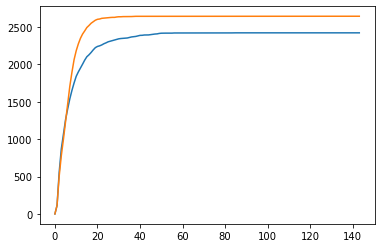

In [127]:
station_distances = np.load('./raw_data/station_distances.npy')

TIME_CONSTRAINS = np.int32(station_distances) * 10 + 10
direct_time = np.zeros(144)
for d in direct_env.dispatchs_arrived:
    s = d.sender_station
    r = d.receiver_station
    t = d.arrive_step-d.send_step
    if t <= TIME_CONSTRAINS[s, r]:
        direct_time[t] += 1

PPO_time = np.zeros(144)
for d in PPO_env.dispatchs_arrived:
    s = d.sender_station
    r = d.receiver_station
    t = d.arrive_step-d.send_step
    if t <= TIME_CONSTRAINS[s, r]:
        PPO_time[(d.arrive_step-d.send_step)] += 1
plt.plot(np.arange(144), np.cumsum(direct_time))
plt.plot(np.arange(144), np.cumsum(PPO_time))
# plt.plot(np.arange(144), np.cumsum(direct_time/direct_time.sum()))
# plt.plot(np.arange(144), np.cumsum(PPO_time/PPO_time.sum()))

In [130]:
print(len(PPO_env.dispatchs_waiting))
print(len(PPO_env.dispatchs_delivering))
print(len(PPO_env.dispatchs_arrived))
print(len(PPO_env.dispatchs_selected))
print(len(direct_env.dispatchs_waiting))
print(len(direct_env.dispatchs_delivering))
print(len(direct_env.dispatchs_arrived))
print(len(direct_env.dispatchs_selected))

170
1
2768
61
0
0
2845
155


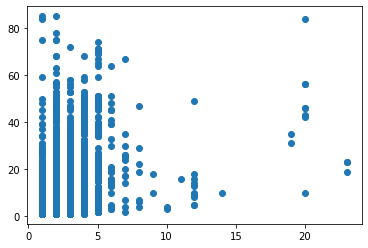

In [129]:
station_distances = np.load('./raw_data/station_distances.npy')
ds = []
ts = []
for d in direct_env.dispatchs_arrived:
    s = d.sender_station
    r = d.receiver_station
    t = d.arrive_step-d.send_step
    ts.append(t)
    ds.append(int(station_distances[s, r])+1)
plt.scatter(ds, ts)

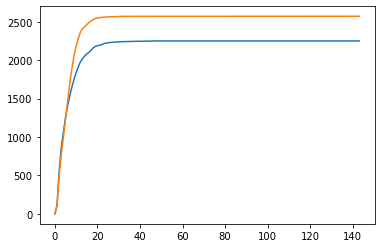

In [6]:
import pickle
import numpy as np
from rl_env_v2 import TIME_CONSTRAINS, Myenv, Dispatch
import matplotlib.pyplot as plt

with open('./analyze/direct.pkl', 'rb') as f:
    direct_env = pickle.load(f)

with open('./analyze/PPOv2.pkl', 'rb') as f:
    PPO_env = pickle.load(f)

station_distances = np.load('./raw_data/station_distances.npy')

TIME_CONSTRAINS = np.zeros((118, 118))
distances_split = [-1, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, np.inf]

for i in range(1, 9):
    dis_map = np.logical_and(station_distances>=distances_split[i-1], station_distances<distances_split[i])
    TIME_CONSTRAINS[dis_map] = i *6

direct_time = np.zeros(144)
for d in direct_env.dispatchs_arrived:
    s = d.sender_station
    r = d.receiver_station
    t = d.arrive_step-d.send_step
    if t <= TIME_CONSTRAINS[s, r]:
        direct_time[t] += 1

PPO_time = np.zeros(144)
for d in PPO_env.dispatchs_arrived:
    s = d.sender_station
    r = d.receiver_station
    t = d.arrive_step-d.send_step
    if t <= TIME_CONSTRAINS[s, r]:
        PPO_time[(d.arrive_step-d.send_step)] += 1
plt.plot(np.arange(144), np.cumsum(direct_time))
plt.plot(np.arange(144), np.cumsum(PPO_time))

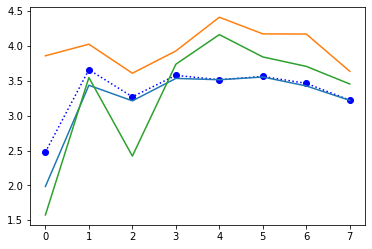

In [77]:
import pickle
import numpy as np
from rl_env_v2 import TIME_CONSTRAINS, Myenv, Dispatch
import matplotlib.pyplot as plt
import torch 
import random
DELTA = torch.load('./dataset/delta.pth')
station_distances = np.load('./raw_data/station_distances.npy')

TIME_CONSTRAINS = np.zeros((118, 118))
distances_split = [-1, 1, 1.5, 2, 2.5, 3, 3.5, 4, np.inf]


pro_step = np.zeros((118, 118))
pro_price = np.zeros((118, 118))

custpay = 5
hoppay = 1

time_class = np.zeros((118, 118))
for i in range(1, 9):
    dis_map = np.logical_and(station_distances>=distances_split[i-1], station_distances<distances_split[i])
    TIME_CONSTRAINS[dis_map] = i * 6
    time_class[dis_map] = i - 1
    pro_step[dis_map] = i * 1
    pro_price[dis_map] = i * 0.5
pro_price = pro_price.clip(1, 3)

dd_split = [-1, 1, 3, 5, 7, 9, np.inf]
distance_class = np.zeros((118, 118))
for i in range(1, 7):
    dis_map = np.logical_and(station_distances>=dd_split[i-1], station_distances<dd_split[i])
    distance_class[dis_map] = i - 1

with open('./analyze/PPOv2.pkl', 'rb') as f:
    PPO_env_m = pickle.load(f)

with open('./analyze/distance_greedy.pkl', 'rb') as f:
    greedy_env = pickle.load(f)

profit_rate_PPO_m = np.zeros(8)
delivery_num_PPO_m = np.zeros(8)
average_hop_PPO_m = np.zeros(8)
ctime_mean_PPO_m = np.zeros(8)

profit_rate_PPO_n = np.zeros(8)
delivery_num_PPO_n = np.zeros(8)
average_hop_PPO_n = np.zeros(8)
ctime_mean_PPO_n = np.zeros(8)

time_split_count = np.zeros(8)


profit_rate_PPO_m_distance = np.zeros(6)
delivery_num_PPO_m_distance = np.zeros(6)
average_hop_PPO_m_distance = np.zeros(6)
ctime_mean_PPO_m_distance = np.zeros(6)

profit_rate_PPO_n_distance = np.zeros(6)
delivery_num_PPO_n_distance = np.zeros(6)
average_hop_PPO_n_distance = np.zeros(6)
ctime_mean_PPO_n_distance = np.zeros(6)

distance_split_count = np.zeros(6)

for d in PPO_env_m.dispatchs_arrived:
    time_split_class = int(time_class[d.sender_station, d.receiver_station])
    distance_split_class = int(distance_class[d.sender_station, d.receiver_station])
    for i in range(0, len(d.hops)-1):
        s = d.hops[i]
        r = d.hops[i+1]
        step = d.states[i, -1]
        predict_time = DELTA[int(step), s, r]
        constrain = TIME_CONSTRAINS[s, r]
        if  predict_time > constrain:
            if step + pro_step[s, r] - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
                profit_rate_PPO_m[time_split_class] += custpay - i - pro_price[s, r]
                delivery_num_PPO_m[time_split_class] += 1
                average_hop_PPO_m[time_split_class] += i + 1
                ctime_mean_PPO_m[time_split_class] += step + pro_step[s, r] - d.send_step

                profit_rate_PPO_m_distance[distance_split_class] += custpay - i - pro_price[s, r]
                delivery_num_PPO_m_distance[distance_split_class] += 1
                average_hop_PPO_m_distance[distance_split_class] += i + 1
                ctime_mean_PPO_m_distance[distance_split_class] += step + pro_step[s, r] - d.send_step
            break
    else:
        if d.arrive_step - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
            profit_rate_PPO_m[time_split_class] += custpay - (len(d.hops) - 1)
            delivery_num_PPO_m[time_split_class] += 1
            average_hop_PPO_m[time_split_class] += len(d.hops) - 1
            ctime_mean_PPO_m[time_split_class] += d.arrive_step -d.send_step

            profit_rate_PPO_m_distance[distance_split_class] += custpay - (len(d.hops) - 1)
            delivery_num_PPO_m_distance[distance_split_class] += 1
            average_hop_PPO_m_distance[distance_split_class] += len(d.hops) - 1
            ctime_mean_PPO_m_distance[distance_split_class] += d.arrive_step-d.send_step

    if d.arrive_step - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
        profit_rate_PPO_n[time_split_class] += custpay - (len(d.hops) - 1)
        delivery_num_PPO_n[time_split_class] += 1
        average_hop_PPO_n[time_split_class] += len(d.hops) - 1
        ctime_mean_PPO_n[time_split_class] += d.arrive_step-d.send_step

        profit_rate_PPO_n_distance[distance_split_class] += custpay - (len(d.hops) - 1)
        delivery_num_PPO_n_distance[distance_split_class] += 1
        average_hop_PPO_n_distance[distance_split_class] += len(d.hops) - 1
        ctime_mean_PPO_n_distance[distance_split_class] += d.arrive_step-d.send_step
    # else:
    #     profit_rate_PPO_n[time_split_class] +=  - (len(d.hops) - 1)
    #     average_hop_PPO_n[time_split_class] += len(d.hops) - 1
    #     ctime_mean_PPO_n[time_split_class] += d.arrive_step-d.send_step

    #     profit_rate_PPO_n_distance[distance_split_class] += - (len(d.hops) - 1)
    #     average_hop_PPO_n_distance[distance_split_class] += len(d.hops) - 1
    #     ctime_mean_PPO_n_distance[distance_split_class] += d.arrive_step-d.send_step
    distance_split_count[distance_split_class] += 1
    time_split_count[time_split_class] += 1


profit_rate_direct_m = np.zeros(8)
delivery_num_direct_m = np.zeros(8)
average_hop_direct_m = np.zeros(8)
ctime_mean_direct_m = np.zeros(8)

profit_rate_direct_n = np.zeros(8)
delivery_num_direct_n = np.zeros(8)
average_hop_direct_n = np.zeros(8)
ctime_mean_direct_n = np.zeros(8)

time_split_count_direct = np.zeros(8)


profit_rate_direct_m_distance = np.zeros(6)
delivery_num_direct_m_distance = np.zeros(6)
average_hop_direct_m_distance = np.zeros(6)
ctime_mean_direct_m_distance = np.zeros(6)

profit_rate_direct_n_distance = np.zeros(6)
delivery_num_direct_n_distance = np.zeros(6)
average_hop_direct_n_distance = np.zeros(6)
ctime_mean_direct_n_distance = np.zeros(6)

distance_split_count_direct = np.zeros(6)

for d in direct_env.dispatchs_arrived:
    time_split_class = int(time_class[d.sender_station, d.receiver_station])
    distance_split_class = int(distance_class[d.sender_station, d.receiver_station])
    for i in range(0, len(d.hops)-1):
        s = d.hops[i]
        r = d.hops[i+1]
        step = d.states[i, -1]
        predict_time = DELTA[int(step), s, r]
        constrain = TIME_CONSTRAINS[s, r]
        if  predict_time > constrain:
            if step + pro_step[s, r] - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
                profit_rate_direct_m[time_split_class] += custpay - i - pro_price[s, r]
                delivery_num_direct_m[time_split_class] += 1
                average_hop_direct_m[time_split_class] += i + 1
                ctime_mean_direct_m[time_split_class] += step + pro_step[s, r] - d.send_step

                profit_rate_direct_m_distance[distance_split_class] += custpay - i - pro_price[s, r]
                delivery_num_direct_m_distance[distance_split_class] += 1
                average_hop_direct_m_distance[distance_split_class] += i + 1
                ctime_mean_direct_m_distance[distance_split_class] += step + pro_step[s, r] - d.send_step
            break
    else:
        if d.arrive_step - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
            profit_rate_direct_m[time_split_class] += custpay - (len(d.hops) - 1)
            delivery_num_direct_m[time_split_class] += 1
            average_hop_direct_m[time_split_class] += len(d.hops) - 1
            ctime_mean_direct_m[time_split_class] += d.arrive_step -d.send_step

            profit_rate_direct_m_distance[distance_split_class] += custpay - (len(d.hops) - 1)
            delivery_num_direct_m_distance[distance_split_class] += 1
            average_hop_direct_m_distance[distance_split_class] += len(d.hops) - 1
            ctime_mean_direct_m_distance[distance_split_class] += d.arrive_step-d.send_step

    if d.arrive_step - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
        profit_rate_direct_n[time_split_class] += custpay - (len(d.hops) - 1)
        delivery_num_direct_n[time_split_class] += 1
        average_hop_direct_n[time_split_class] += len(d.hops) - 1
        ctime_mean_direct_n[time_split_class] += d.arrive_step-d.send_step

        profit_rate_direct_n_distance[distance_split_class] += custpay - (len(d.hops) - 1)
        delivery_num_direct_n_distance[distance_split_class] += 1
        average_hop_direct_n_distance[distance_split_class] += len(d.hops) - 1
        ctime_mean_direct_n_distance[distance_split_class] += d.arrive_step-d.send_step
    # else:
    #     profit_rate_PPO_n[time_split_class] +=  - (len(d.hops) - 1)
    #     average_hop_PPO_n[time_split_class] += len(d.hops) - 1
    #     ctime_mean_PPO_n[time_split_class] += d.arrive_step-d.send_step

    #     profit_rate_PPO_n_distance[distance_split_class] += - (len(d.hops) - 1)
    #     average_hop_PPO_n_distance[distance_split_class] += len(d.hops) - 1
    #     ctime_mean_PPO_n_distance[distance_split_class] += d.arrive_step-d.send_step
    distance_split_count_direct[distance_split_class] += 1
    time_split_count_direct[time_split_class] += 1


profit_rate_greedy_m = np.zeros(8)
delivery_num_greedy_m = np.zeros(8)
average_hop_greedy_m = np.zeros(8)
ctime_mean_greedy_m = np.zeros(8)

time_split_count_greedy = np.zeros(8)

profit_rate_greedy_m_distance = np.zeros(6)
delivery_num_greedy_m_distance = np.zeros(6)
average_hop_greedy_m_distance = np.zeros(6)
ctime_mean_greedy_m_distance = np.zeros(6)


distance_split_count_greedy = np.zeros(6)

for d in greedy_env.dispatchs_arrived:
    time_split_class = int(time_class[d.sender_station, d.receiver_station])
    distance_split_class = int(distance_class[d.sender_station, d.receiver_station])
    for i in range(0, len(d.hops)-1):
        s = d.hops[i]
        r = d.hops[i+1]
        step = d.states[i, -1]
        predict_time = DELTA[int(step), s, r]
        constrain = TIME_CONSTRAINS[s, r]
        if  predict_time > constrain:
            if step + pro_step[s, r] - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
                profit_rate_direct_m[time_split_class] += custpay - i - pro_price[s, r]
                delivery_num_direct_m[time_split_class] += 1
                average_hop_direct_m[time_split_class] += i + 1
                ctime_mean_direct_m[time_split_class] += step + pro_step[s, r] - d.send_step

                profit_rate_direct_m_distance[distance_split_class] += custpay - i - pro_price[s, r]
                delivery_num_direct_m_distance[distance_split_class] += 1
                average_hop_direct_m_distance[distance_split_class] += i + 1
                ctime_mean_direct_m_distance[distance_split_class] += step + pro_step[s, r] - d.send_step
            break
    else:
        if d.arrive_step - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
            profit_rate_direct_m[time_split_class] += custpay - (len(d.hops) - 1)
            delivery_num_direct_m[time_split_class] += 1
            average_hop_direct_m[time_split_class] += len(d.hops) - 1
            ctime_mean_direct_m[time_split_class] += d.arrive_step -d.send_step

            profit_rate_direct_m_distance[distance_split_class] += custpay - (len(d.hops) - 1)
            delivery_num_direct_m_distance[distance_split_class] += 1
            average_hop_direct_m_distance[distance_split_class] += len(d.hops) - 1
            ctime_mean_direct_m_distance[distance_split_class] += d.arrive_step-d.send_step

    if d.arrive_step - d.send_step <= TIME_CONSTRAINS[d.sender_station, d.receiver_station]:
        profit_rate_direct_n[time_split_class] += custpay - (len(d.hops) - 1)
        delivery_num_direct_n[time_split_class] += 1
        average_hop_direct_n[time_split_class] += len(d.hops) - 1
        ctime_mean_direct_n[time_split_class] += d.arrive_step-d.send_step

        profit_rate_direct_n_distance[distance_split_class] += custpay - (len(d.hops) - 1)
        delivery_num_direct_n_distance[distance_split_class] += 1
        average_hop_direct_n_distance[distance_split_class] += len(d.hops) - 1
        ctime_mean_direct_n_distance[distance_split_class] += d.arrive_step-d.send_step
    # else:
    #     profit_rate_PPO_n[time_split_class] +=  - (len(d.hops) - 1)
    #     average_hop_PPO_n[time_split_class] += len(d.hops) - 1
    #     ctime_mean_PPO_n[time_split_class] += d.arrive_step-d.send_step

    #     profit_rate_PPO_n_distance[distance_split_class] += - (len(d.hops) - 1)
    #     average_hop_PPO_n_distance[distance_split_class] += len(d.hops) - 1
    #     ctime_mean_PPO_n_distance[distance_split_class] += d.arrive_step-d.send_step
    distance_split_count_direct[distance_split_class] += 1
    time_split_count_direct[time_split_class] += 1


plt.plot(np.arange(8), profit_rate_PPO_m/time_split_count, "ob:")
plt.plot(np.arange(8), profit_rate_PPO_n/time_split_count)
plt.plot(np.arange(8), profit_rate_direct_m/time_split_count)
plt.plot(np.arange(8), profit_rate_direct_n/time_split_count)
# plt.plot(np.arange(6), profit_rate_PPO_m_distance/distance_split_count, "ob:")
# plt.plot(np.arange(6), profit_rate_PPO_n_distance/distance_split_count)

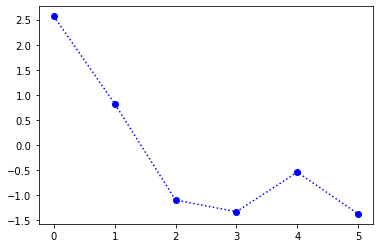

In [136]:
with open('./analyze/distance_greedy.pkl', 'rb') as f:
    greedy_env = pickle.load(f)
profit = np.zeros(6)
arrived = np.zeros(6)
hops = np.zeros(6)
count = np.zeros(6)
valid = np.zeros(6)
for d in greedy_env.dispatchs_arrived + greedy_env.dispatchs_waiting + greedy_env.dispatchs_delivering + greedy_env.dispatchs_selected:
    distance_split_class = int(distance_class[d.sender_station, d.receiver_station])
    if d.status=="arrived":
        if d.arrive_step - d.send_step <= 48:
            profit[distance_split_class] += 5 - (len(d.hops)-1)
            arrived[distance_split_class] += 1
            hops[distance_split_class] += len(d.hops)-1
            valid[distance_split_class] += 1
        # else:
        #     profit[distance_split_class] +=  - len(d.hops) + 1
        #     # arrived[distance_split_class] += 1
        #     hops[distance_split_class] += len(d.hops) -1
    # else:
    #     profit[distance_split_class] +=  - len(d.hops)
    #     # arrived[distance_split_class] += 1
    #     hops[distance_split_class] += len(d.hops)
    #     # valid[distance_split_class] += 1
    count[distance_split_class] += 1

plt.plot(np.arange(6), profit/count, "ob:")
import pickle
with open('analyze/greedy_info.pkl', 'wb') as f:
    pickle.dump([profit, arrived, hops, count, valid], f)

In [165]:
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rc("font",family='YouYuan')
print(matplotlib.matplotlib_fname())
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False
# file_paths = ['analyze/PPO_full_info.pkl', 'analyze/PPO_info.pkl', 'analyze/direct_full_info.pkl', 'analyze/direct_info.pkl', 'analyze/greedy_info.pkl']
# datas = []
# for i in range(5):
#     with open(file_paths[i], 'rb') as f:
#         datas.append(pickle.load(f))

# i = 0
# datas[1][i][4] -= 2

# plt.xlabel('距离(km)') 
# plt.ylabel('收益率') 
# plt.grid(b=True)
# plt.xticks([0, 2, 4, 6, 8, 10])
# plt.plot(np.arange(6), datas[0][i]/datas[0][3], 'bv-')
# plt.plot(np.arange(6), datas[1][i]/datas[1][3], 'y^--')
# plt.plot(np.arange(6), datas[2][i]/datas[2][3] - np.array([0.3, 0, 0.3, 0, 0, 0]), 'gd:')
# plt.plot(np.arange(6), datas[3][i]/datas[3][3] - np.array([0.3, 0, 0.3, 0, 0, 0.2]), 'c*-.')
# plt.plot(np.arange(6), datas[4][i]/datas[4][3], 'mo:')

/data1/dispatch_RLv1/.conda/envs/RL-dispatch/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc
